In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


plt.ion()

#GPU
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

### 重放记忆

In [2]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward')) #命名元组

class ReplayMemory(object):

    def __init__(self, capacity): #初始化
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args): #添加transition
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity # %取余数，可以循环

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Q网络

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### 环境和获得裁剪后的帧图片

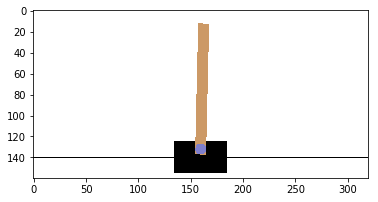

In [4]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

screen_width = 600 #设置屏幕宽度，由每个env的render决定

def get_cart_location():#获得小车的中间位置在屏幕坐标上位置
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) 

def get_screen(): #获得修改后的屏幕图像
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # 转成Tensro格式 (CHW)
    # 裁剪图片的上下
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 进行左右切片
    screen = screen[:, :, slice_range]
    plt.imshow(screen.transpose((1,2,0)))
    
    #screen = np.ascontiguousarray(screen, dtype=np.float32) / 255 #返回一个内存中的连续数组
    screen = np.float32(screen) / 255 #好像也不用
    screen = torch.from_numpy(screen) #32位的才能转换
    # 调整大小(BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

get_screen()
env.render(close=True)
env.close()

### 超参数

### 动作策略

In [5]:
def select_action(state): #策略：e贪婪法选择动作的策略
    global steps_done
    sample = random.random() #产生一个随机数
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY) #一个衰减的eps
    eps_threshold = EPS_END
    steps_done += 1 
    if sample > eps_threshold: #如果随机数大于eps
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1) #Q网络输出的0和1
    else:
        return LongTensor([[random.randrange(2)]]) #否则随机选择0和1

### 绘制片段持续时间
横坐标是片段   
纵坐标是持续时间   

In [6]:
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 采样100片段的平均值然后绘制
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        print(means)

    plt.pause(0.001)  # 每一帧暂停一会
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [7]:
last_sync = 0

def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE: #如果记忆长度小于batch_size就返回
        return
    transitions = memory.sample(BATCH_SIZE) #取一个batch_size长度的transitions
    batch = Transition(*zip(*transitions)) #打一下包

    # 非最终状态的掩码,也就是没结束的s-a-s，打上True标记
    non_final_mask = tuple(map(lambda s: s is not None, batch.next_state))
    non_final_mask = ByteTensor(non_final_mask)

    # 我们不希望反向传播 expected action values
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))


    state_action_values = model(state_batch).gather(1, action_batch) #计算Q(s,a)

    # 对所有nest_stats计算 V(s_{t+1}) 
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor)) #全0
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0] #取最大的一个，动作
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # loss
    #loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    loss = torch.nn.MSELoss()(state_action_values, expected_state_action_values)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #for param in model.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss

### 超参数

In [ ]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 200
num_episodes = 500

model = DQN().cuda()

optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Adam(model.parameters(),lr=1e-3)
memory = ReplayMemory(100000) #10000个重放记忆

steps_done = 0

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

for i_episode in range(num_episodes):
    # 初始化环境
    env.reset()
    last_screen = get_screen() #获得环境的图像
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count(): #无限循环
        action = select_action(state) #选择一个动作
        _, reward, done, _ = env.step(action[0, 0]) #计算该动作的奖励，done
        reward = Tensor([reward]) #存储奖励

        # 观察状态
        last_screen = current_screen #上一个屏幕状态等于当前屏幕状态
        current_screen = get_screen() #当前屏幕状态重新获取
        if not done: #如果没有结束
            next_state = current_screen - last_screen #下一个状态位当前屏幕状态-上一个屏幕状态
        else:
            next_state = None

        # 把transtion存入重放记忆
        memory.push(state, action, next_state, reward)

        # 变成下一个状态
        state = next_state

        # Perform one step of the optimization (on the target network)
        for i in range(1):
            loss = optimize_model()
        if done:
            #episode_durations.append(t + 1)
            #plot_durations()
            writer.add_scalar('t', t, i_episode)
            #print(i_episode, t)
            break

print('Complete')
writer.close()
#env.render(close=True)
#env.close()

Traceback (most recent call last):
  File "/Users/lhan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-9b71f40c1e3d>", line 12, in <module>
    _, reward, done, _ = env.step(action[0, 0]) #计算该动作的奖励，done
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lhan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lhan/anaconda3/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1090, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/l

KeyboardInterrupt: 